In [1]:
pip install sciplotlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
pip install roifile

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import sciplotlib.style as splstyle
from tifffile import imsave
import zipfile
from roifile import ImagejRoi
import shutil


# Loop through all subfolders in the inputfolder

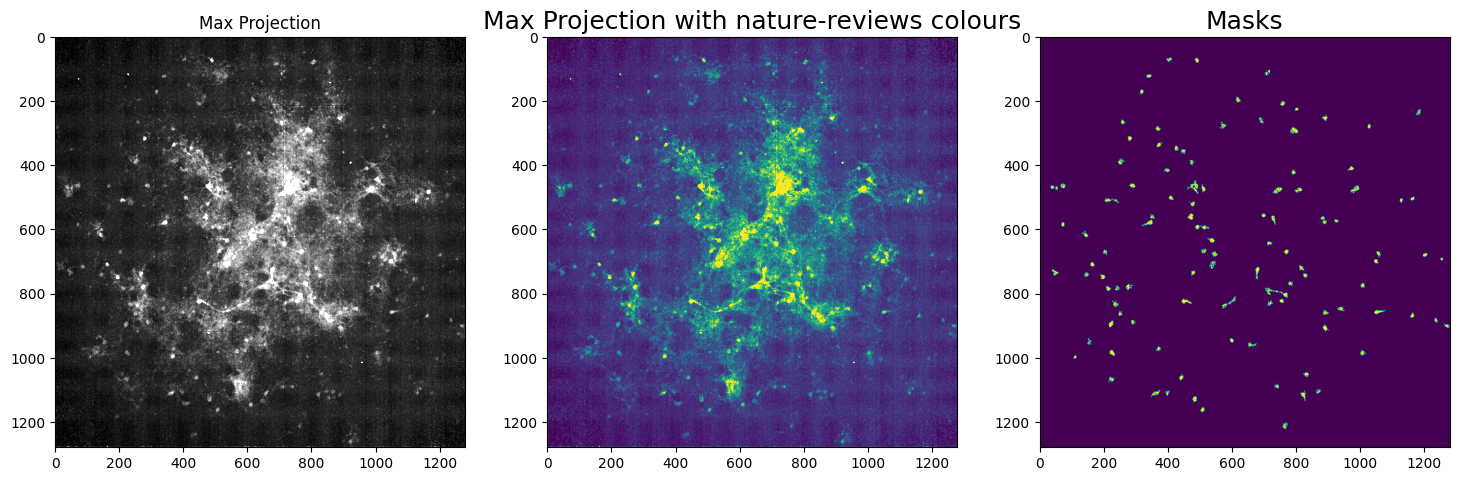

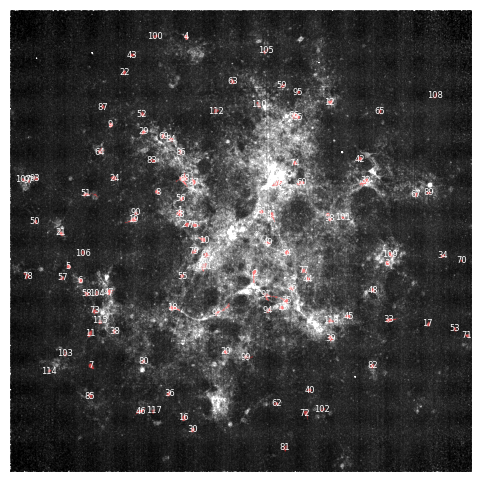

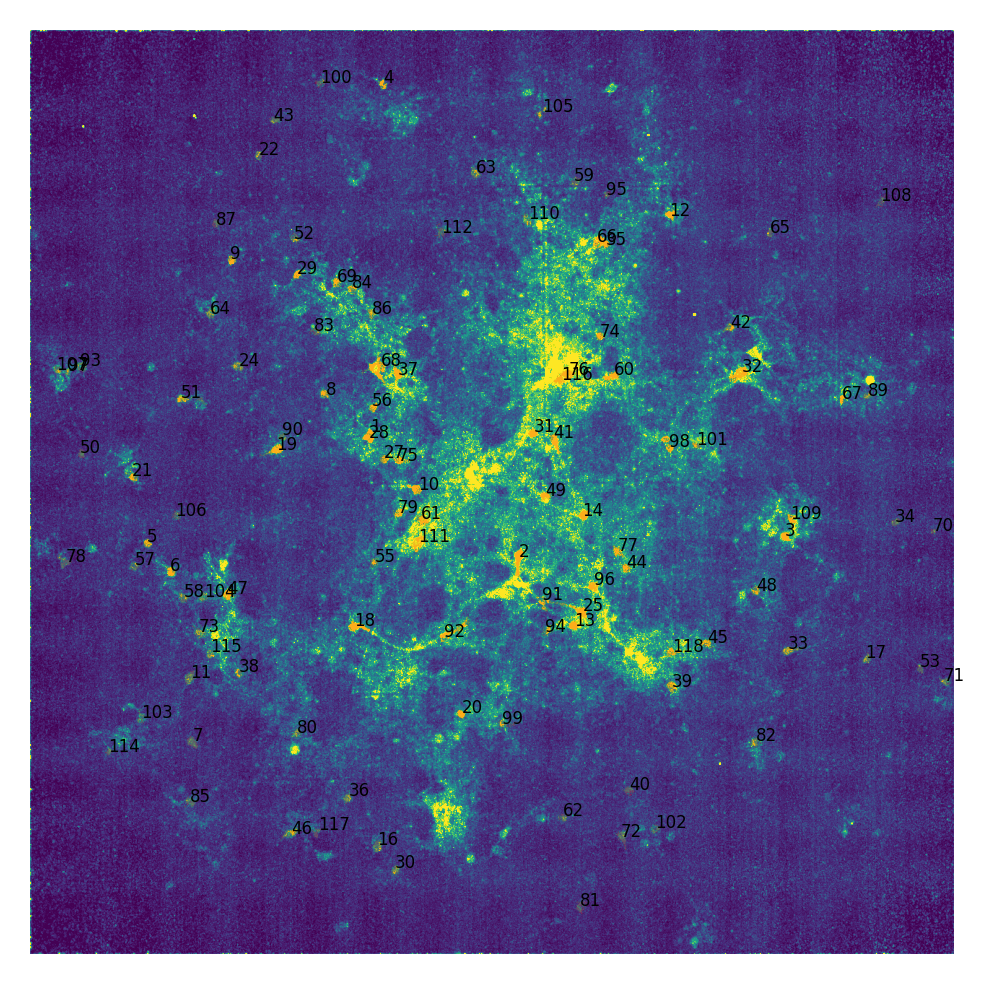

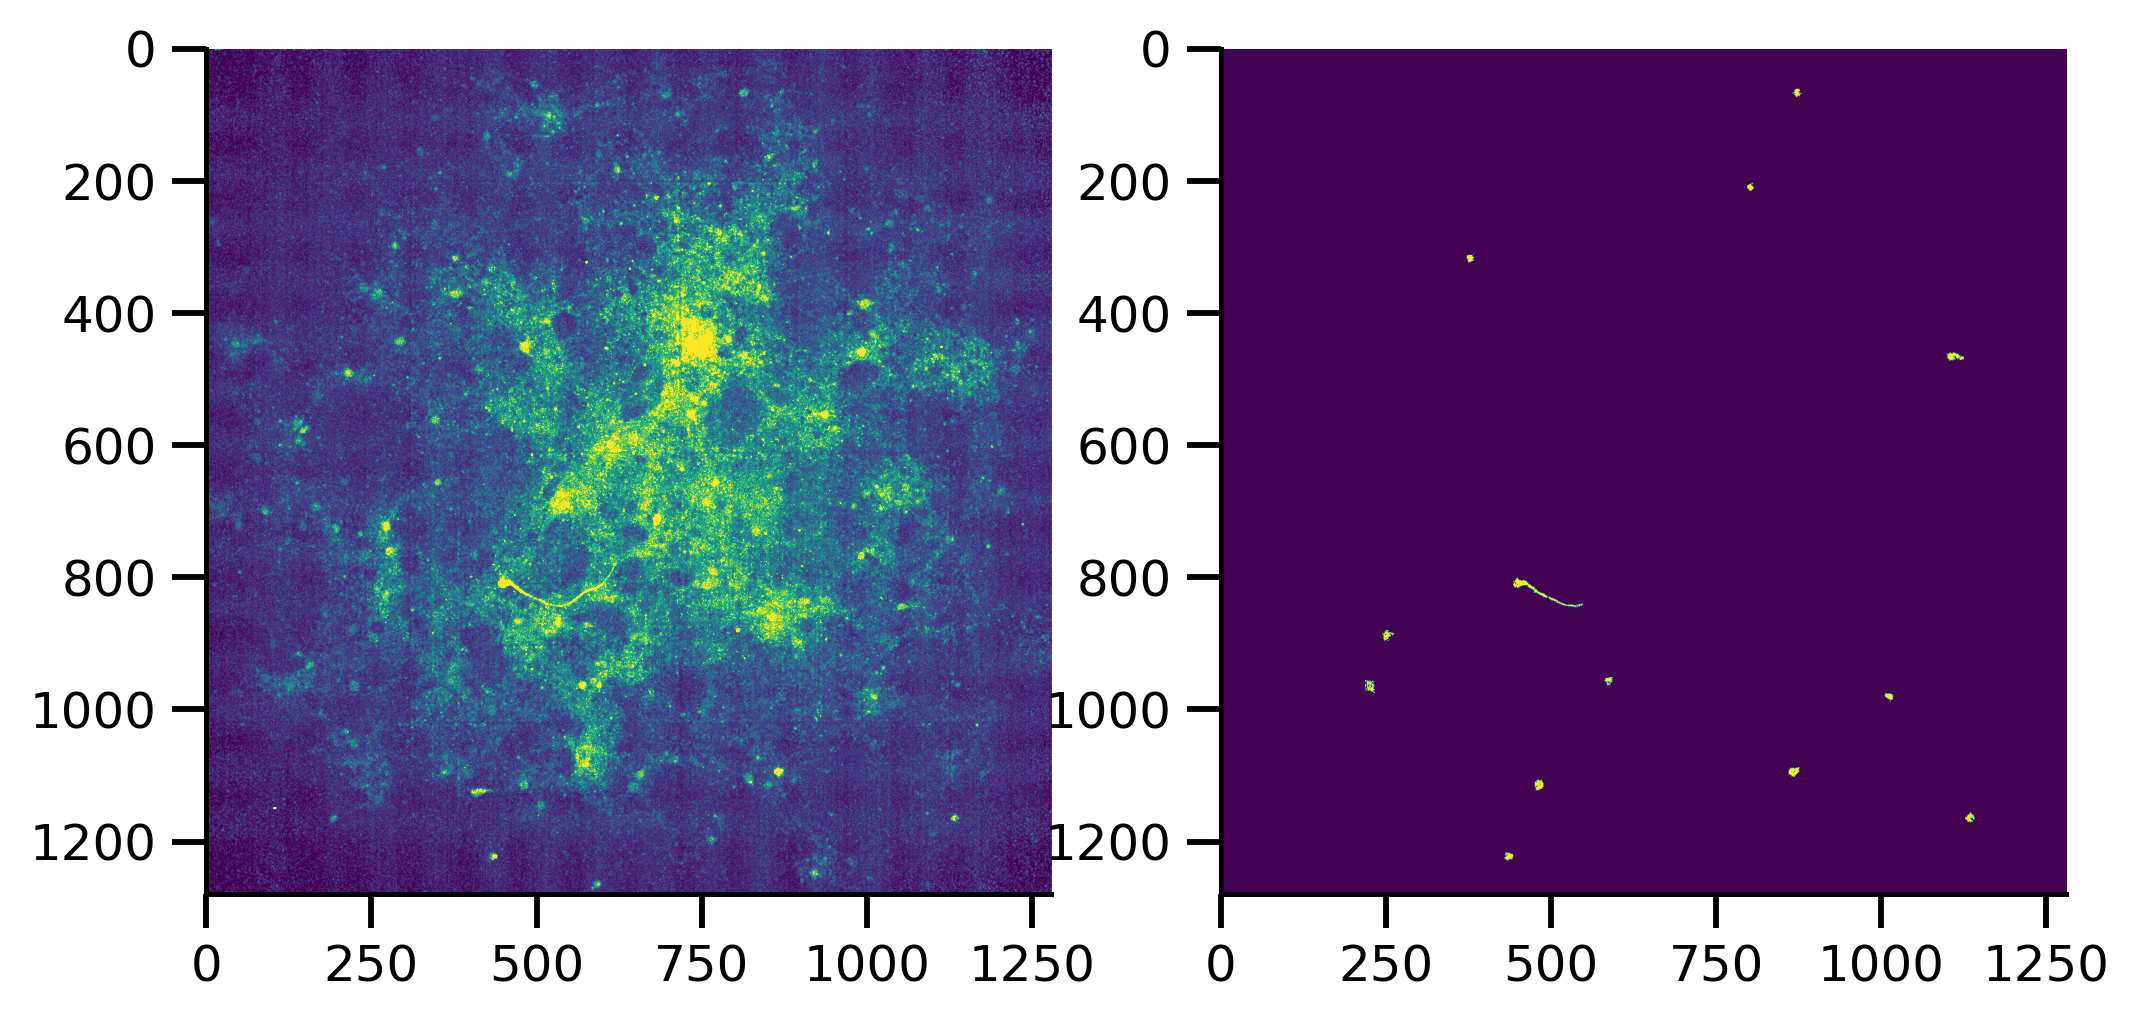

C:\Users\sandbox\AppData\Local\Temp\ipykernel_508\271747947.py:109: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  imsave(os.path.join(output_folder,'maxProj.tif'), normalized_maxproj_image)


Images saved successfully.
ROIs saved successfully to D:\Cambridge University Dropbox\Susanna B. Mierau\Suite2p&IF_Image_Analysis\Suite2pOutputs_NoTiff\OPME20240607culture - DIV42\OPME240607_6p2_20240719_P1_pup1B_WT_MOI50000_DIV42\suite2p\plane0\ROI_Output\fiji_rois.zip.


In [49]:
# Define the main input folder
inputfolder = r'D:\Cambridge University Dropbox\Susanna B. Mierau\Suite2p&IF_Image_Analysis\Suite2pOutputs_NoTiff\OPME20240607culture - DIV42\OPME240607_6p2_20240719_P1_pup1B_WT_MOI50000_DIV42\suite2p\plane0'

# Traverse all subdirectories in the input folder
for root, dirs, files in os.walk(inputfolder):
    # Look for the specific 'suite2p/plane0' structure in each subdirectory
    if 'suite2p' in root and 'plane0' in root:
        suite2pfolder = root
        output_folder = os.path.join(suite2pfolder, 'ROI_Output')
        # Check if the folder exists and remove it if it does
        if os.path.exists(output_folder):
            shutil.rmtree(output_folder)
        # Create a new empty folder
        os.makedirs(output_folder, exist_ok=True)

        # Paths for stat.npy and iscell.npy
        stat_path = os.path.join(suite2pfolder, 'stat.npy')
        iscell_path = os.path.join(suite2pfolder, 'iscell.npy')

        # Check if the required files exist
        if os.path.exists(stat_path) and os.path.exists(iscell_path):
            # Load the ops dictionary & .npy files
            ops = np.load(os.path.join(suite2pfolder, 'ops.npy'), allow_pickle=True).item()
            iscell = np.load(iscell_path, allow_pickle=True)
            iscell_index = np.where(iscell[:, 0] == 1)[0]
            stat = np.load(stat_path, allow_pickle=True)
                
            # Assuming `ops['max_proj']` is a numpy array
            if 'max_proj' in ops:
                image_data = ops['max_proj']
            elif 'meanImg' in ops:
                image_data = ops['meanImg']
            else:
                raise KeyError("Neither 'max_proj' nor 'meanImg' found in ops.")

            # Set vmin and vmax dynamically based on percentiles or manually
            vmin = np.percentile(image_data, 1)  # e.g., 1st percentile
            vmax = np.percentile(image_data, 99)  # e.g., 99th percentile
            # Alternatively, set manually: vmin = 0, vmax = 100
            # mask 
            mask_image = np.zeros(np.shape(ops['meanImg']))
            fill_val = 1

            for n_cell, cell_stat in enumerate(stat[iscell_index]):
                mask_image[cell_stat['ypix'], cell_stat['xpix']] = fill_val
                
            with plt.style.context(splstyle.get_style('nature-reviews')):
                fig, axs = plt.subplots(1, 2)
                fig.set_size_inches(8, 4)

                if 'max_proj' in ops:
                    axs[0].imshow(ops['max_proj'], vmin=vmin, vmax=vmax)
                elif 'meanImg' in ops:
                    axs[0].imshow(ops['meanImg'], vmin=vmin, vmax=vmax)
                else:
                    raise KeyError("Neither 'max_proj' nor 'meanImg' found in ops.")
                
                axs[1].imshow(mask_image)



            # Show the plot
            plt.show()

            # Create a single figure with 3 subplots
            fig, axs = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns


            # Plot 1: Max Projection with Gray scale
            axs[0].imshow(image_data, vmin=vmin, vmax=vmax, cmap='gray')  # Use desired colormap
            axs[0].set_title("Max Projection")

            with plt.style.context(splstyle.get_style('nature-reviews')):
                # Plot 2: Max Projection with nature-reviews colours
                if 'max_proj' in ops:
                    axs[1].imshow(ops['max_proj'], vmin=vmin, vmax=vmax)
                elif 'meanImg' in ops:
                    axs[1].imshow(ops['meanImg'], vmin=vmin, vmax=vmax)
                else:
                    raise KeyError("Neither 'max_proj' nor 'meanImg' found in ops.")
                axs[1].set_title("Max Projection with nature-reviews colours")

                # Plot 3: Masks
                axs[2].imshow(mask_image)
                axs[2].set_title("Masks")

            # Save the entire figure as a TIFF
            fig.savefig(os.path.join(output_folder,'raw_mask_check.tif'), dpi=300, format='tiff', bbox_inches='tight')








            # Create the mask image with transparency (RGBA format)
            image_dim = image_data.shape
            mask_image2 = np.zeros((image_dim[0], image_dim[1], 4), dtype=np.float32)
            for n_cell, cell_stat in enumerate(stat[iscell_index]):
                cell_stat['ypix'] = np.clip(cell_stat['ypix'], 0, image_dim[0] - 1)
                cell_stat['xpix'] = np.clip(cell_stat['xpix'], 0, image_dim[1] - 1)
                mask_image2[cell_stat['ypix'], cell_stat['xpix']] = [1, 0, 0, 0.5]  # Red with 50% transparency

            # Save the raw max projection figure 
            normalized_maxproj_image = np.clip((image_data - vmin) / (vmax - vmin), 0, 1) # Normalize the image data based on vmin and vmax
            normalized_maxproj_image = (normalized_maxproj_image * 255).astype(np.uint8)  # For 8-bit # Convert to 8-bit or 16-bit (depending on your data type preference)
            # Save the image as a TIFF file
            imsave(os.path.join(output_folder,'maxProj.tif'), normalized_maxproj_image)

            # Create the figure and overlay
            fig, ax = plt.subplots(figsize=(6, 6))
            ax.imshow(image_data, vmin=vmin, vmax=vmax, cmap='gray')
            ax.imshow(mask_image2)

            # Annotate cell IDs
            for n_cell, cell_stat in enumerate(stat[iscell_index]):
                ax.text(cell_stat['med'][1], cell_stat['med'][0], iscell_index[n_cell], 
                        color='white', fontsize=6, ha='center', va='center')
                
            # Remove axes and make the figure as large as the figure setting
            ax.axis('off')
            # Save as TIFF
            fig.savefig(os.path.join(output_folder,'maxProj_ROImask_ID_grayScale.tif'), dpi=300, bbox_inches='tight')

            with plt.style.context(splstyle.get_style('nature-reviews')):
                fig, ax = plt.subplots()
                fig.set_size_inches(4, 4)
                if 'max_proj' in ops:
                    ax.imshow(ops['max_proj'], vmin=vmin, vmax=vmax)
                elif 'meanImg' in ops:
                    ax.imshow(ops['meanImg'], vmin=vmin, vmax=vmax)
                else:
                    raise KeyError("Neither 'max_proj' nor 'meanImg' found in ops.")
                ax.imshow(mask_image2, alpha=0.5)
                
                # Plot the number of the cell 
                for n_cell, cell_stat in enumerate(stat[iscell_index]):
                    ax.text(cell_stat['med'][1], cell_stat['med'][0], iscell_index[n_cell], color='black', size=4)
                # Remove axes and make the figure as large as the figure setting
                ax.axis('off')
                fig.savefig(os.path.join(output_folder,'maxProj_ROImask_ID_natureScale.tif'))
                

            print("Images saved successfully.")

            # Save ROI & cell ID for FIJI read-in
            # Folder to save individual ROI files
            os.makedirs(output_folder, exist_ok=True) # Ensure output folder exists
            roi_folder = os.path.join(output_folder, 'fiji_rois') # Define the ROI folder inside the output folder
            os.makedirs(roi_folder, exist_ok=True)

            # Path to save the final ZIP file
            roi_zip_path = os.path.join(output_folder, 'fiji_rois.zip')

            # Generate ROIs for each cell
            roi_files = []
            for n_cell, cell_stat in enumerate(stat[iscell_index]):
                x_coords = cell_stat['xpix']
                y_coords = cell_stat['ypix']

                # Create an ImageJ ROI
                roi = ImagejRoi.frompoints(np.column_stack((x_coords, y_coords)))
                roi.name = f"Cell_{iscell_index[n_cell]}"  # Name the ROI with the cell ID

                # Save the ROI as an individual .roi file
                roi_file_path = os.path.join(roi_folder, f"Cell_{iscell_index[n_cell]}.roi")
                roi.tofile(roi_file_path)
                roi_files.append(roi_file_path)

            # Create a ZIP archive containing all ROIs
            with zipfile.ZipFile(roi_zip_path, 'w') as zipf:
                for file in roi_files:
                    zipf.write(file, arcname=os.path.basename(file))

            print(f"ROIs saved successfully to {roi_zip_path}.")


In [ ]:
# # save mean img & mean img (enhanced)
# inputfolder = r'D:\Cambridge University Dropbox\Susanna B. Mierau\Suite2p&IF_Image_Analysis\Suite2pOutputs_NoTiff\OPME20230825culture - DIV14\OPME230825_1_20230908_P1_pup4A_Het_MOI50000_DIV14'

# # Traverse all subdirectories in the input folder
# for root, dirs, files in os.walk(inputfolder):
#     # Look for the specific 'suite2p/plane0' structure in each subdirectory
#     if 'suite2p' in root and 'plane0' in root:
#         suite2pfolder = root
#         output_folder = os.path.join(suite2pfolder, 'ROI_Output_mean')
#         # Check if the folder exists and remove it if it does
#         if os.path.exists(output_folder):
#             shutil.rmtree(output_folder)
#         # Create a new empty folder
#         os.makedirs(output_folder, exist_ok=True)

#         # Paths for stat.npy and iscell.npy
#         stat_path = os.path.join(suite2pfolder, 'stat.npy')
#         iscell_path = os.path.join(suite2pfolder, 'iscell.npy')

#         # Check if the required files exist
#         if os.path.exists(stat_path) and os.path.exists(iscell_path):
#             # Load the ops dictionary & .npy files
#             ops = np.load(os.path.join(suite2pfolder, 'ops.npy'), allow_pickle=True).item()
#             iscell = np.load(iscell_path, allow_pickle=True)
#             iscell_index = np.where(iscell[:, 0] == 1)[0]
#             stat = np.load(stat_path, allow_pickle=True)
                
#             # Assuming `ops['max_proj']` is a numpy array
#             if 'meanImg' in ops:
#                 image_data = ops['meanImg']
#             elif 'meanImg' in ops:
#                 image_data = ops['meanImg']
#             else:
#                 raise KeyError("Neither 'max_proj' nor 'meanImg' found in ops.")

#             # Set vmin and vmax dynamically based on percentiles or manually
#             vmin = np.percentile(image_data, 1)  # e.g., 1st percentile
#             vmax = np.percentile(image_data, 99)  # e.g., 99th percentile
#             # Alternatively, set manually: vmin = 0, vmax = 100
#             # mask 
#             mask_image = np.zeros(np.shape(ops['meanImg']))
#             fill_val = 1

#             for n_cell, cell_stat in enumerate(stat[iscell_index]):
#                 mask_image[cell_stat['ypix'], cell_stat['xpix']] = fill_val
                
#             with plt.style.context(splstyle.get_style('nature-reviews')):
#                 fig, axs = plt.subplots(1, 2)
#                 fig.set_size_inches(8, 4)

#                 if 'meanImg' in ops:
#                     axs[0].imshow(ops['meanImg'], vmin=vmin, vmax=vmax)
#                 elif 'meanImg' in ops:
#                     axs[0].imshow(ops['meanImg'], vmin=vmin, vmax=vmax)
#                 else:
#                     raise KeyError("Neither 'meanImg' nor 'meanImg' found in ops.")
                
#                 axs[1].imshow(mask_image)



#             # Show the plot
#             plt.show()

#             # Create a single figure with 3 subplots
#             fig, axs = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns


#             # Plot 1: Max Projection with Gray scale
#             axs[0].imshow(image_data, vmin=vmin, vmax=vmax, cmap='gray')  # Use desired colormap
#             axs[0].set_title("mean_image")

#             with plt.style.context(splstyle.get_style('nature-reviews')):
#                 # Plot 2: Max Projection with nature-reviews colours
#                 if 'meanImg' in ops:
#                     axs[1].imshow(ops['meanImg'], vmin=vmin, vmax=vmax)
#                 elif 'meanImg' in ops:
#                     axs[1].imshow(ops['meanImg'], vmin=vmin, vmax=vmax)
#                 else:
#                     raise KeyError("Neither 'max_proj' nor 'meanImg' found in ops.")
#                 axs[1].set_title("mean_image with nature-reviews colours")

#                 # Plot 3: Masks
#                 axs[2].imshow(mask_image)
#                 axs[2].set_title("Masks")

#             # Save the entire figure as a TIFF
#             fig.savefig(os.path.join(output_folder,'raw_mask_check.tif'), dpi=300, format='tiff', bbox_inches='tight')








#             # Create the mask image with transparency (RGBA format)
#             image_dim = image_data.shape
#             mask_image2 = np.zeros((image_dim[0], image_dim[1], 4), dtype=np.float32)
#             for n_cell, cell_stat in enumerate(stat[iscell_index]):
#                 cell_stat['ypix'] = np.clip(cell_stat['ypix'], 0, image_dim[0] - 1)
#                 cell_stat['xpix'] = np.clip(cell_stat['xpix'], 0, image_dim[1] - 1)
#                 mask_image2[cell_stat['ypix'], cell_stat['xpix']] = [1, 0, 0, 0.5]  # Red with 50% transparency

#             # Save the raw max projection figure 
#             normalized_maxproj_image = np.clip((image_data - vmin) / (vmax - vmin), 0, 1) # Normalize the image data based on vmin and vmax
#             normalized_maxproj_image = (normalized_maxproj_image * 255).astype(np.uint8)  # For 8-bit # Convert to 8-bit or 16-bit (depending on your data type preference)
#             # Save the image as a TIFF file
#             imsave(os.path.join(output_folder,'meanProj.tif'), normalized_maxproj_image)

#             # Create the figure and overlay
#             fig, ax = plt.subplots(figsize=(6, 6))
#             ax.imshow(image_data, vmin=vmin, vmax=vmax, cmap='gray')
#             ax.imshow(mask_image2)

#             # Annotate cell IDs
#             for n_cell, cell_stat in enumerate(stat[iscell_index]):
#                 ax.text(cell_stat['med'][1], cell_stat['med'][0], iscell_index[n_cell], 
#                         color='white', fontsize=6, ha='center', va='center')
                
#             # Remove axes and make the figure as large as the figure setting
#             ax.axis('off')
#             # Save as TIFF
#             fig.savefig(os.path.join(output_folder,'meanProj_ROImask_ID_grayScale.tif'), dpi=300, bbox_inches='tight')

#             with plt.style.context(splstyle.get_style('nature-reviews')):
#                 fig, ax = plt.subplots()
#                 fig.set_size_inches(4, 4)
#                 if 'meanImg' in ops:
#                     ax.imshow(ops['meanImg'], vmin=vmin, vmax=vmax)
#                 elif 'meanImg' in ops:
#                     ax.imshow(ops['meanImg'], vmin=vmin, vmax=vmax)
#                 else:
#                     raise KeyError("Neither 'meanImg' nor 'meanImg' found in ops.")
#                 ax.imshow(mask_image2, alpha=0.5)
                
#                 # Plot the number of the cell 
#                 for n_cell, cell_stat in enumerate(stat[iscell_index]):
#                     ax.text(cell_stat['med'][1], cell_stat['med'][0], iscell_index[n_cell], color='black', size=4)
#                 # Remove axes and make the figure as large as the figure setting
#                 ax.axis('off')
#                 fig.savefig(os.path.join(output_folder,'meanProj_ROImask_ID_natureScale.tif'))
                

#             print("Images saved successfully.")


In [5]:
# inputfolder = r'C:\Users\sandbox\Downloads\OPME240517_20_20240630_P1_pup2E_WT_MOI50000_DIV44'
# suite2pfolder = os.path.join(inputfolder, 'suite2p','plane0')
# output_folder = os.path.join(suite2pfolder, 'ROI_Output')
# os.makedirs(output_folder, exist_ok=True)

# stat_path = os.path.join(suite2pfolder, 'stat.npy')
# iscell_path = os.path.join(suite2pfolder, 'iscell.npy')

# iscell = np.load(iscell_path, allow_pickle=True)
# stat = np.load(stat_path, allow_pickle=True)

# iscell_index = np.where(iscell[:, 0])[0]

In [6]:
# import numpy as np
# import matplotlib.pyplot as plt

# # Check distribution to refine vmin & vmax values
# ops = np.load(os.path.join(suite2pfolder,'ops.npy'), allow_pickle=True)
# ops = ops.item()

# # mask 
# mask_image = np.zeros(np.shape(ops['meanImg']))
# fill_val = 1

# for n_cell, cell_stat in enumerate(stat[iscell_index]):
#     mask_image[cell_stat['ypix'], cell_stat['xpix']] = fill_val
    
# with plt.style.context(splstyle.get_style('nature-reviews')):
#     fig, axs = plt.subplots(1, 2)
#     fig.set_size_inches(8, 4)
#     axs[0].imshow(ops['max_proj'], vmin=0, vmax=100)  # 'meanImg', 'max_proj'
#     axs[1].imshow(mask_image)

    
# # Assuming `ops['max_proj']` is a numpy array
# image_data = ops['max_proj']

# # Set vmin and vmax dynamically based on percentiles or manually
# vmin = np.percentile(image_data, 1)  # e.g., 1st percentile
# vmax = np.percentile(image_data, 99)  # e.g., 99th percentile
# # Alternatively, set manually: vmin = 0, vmax = 100

# # Show the plot
# plt.show()

# # Create a single figure with 3 subplots
# fig, axs = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns


# # Plot 1: Max Projection with Gray scale
# axs[0].imshow(image_data, vmin=vmin, vmax=vmax, cmap='gray')  # Use desired colormap
# axs[0].set_title("Max Projection")

# with plt.style.context(splstyle.get_style('nature-reviews')):
#     # Plot 2: Max Projection with nature-reviews colours
#     axs[1].imshow(ops['max_proj'], vmin=vmin, vmax=vmax)  # 'meanImg', 'max_proj'
#     axs[1].set_title("Max Projection with nature-reviews colours")
#     # Plot 3: Masks
#     axs[2].imshow(mask_image)
#     axs[2].set_title("Masks")

# # Save the entire figure as a TIFF
# fig.savefig(os.path.join(output_folder,'raw_mask_check.tif'), dpi=300, format='tiff', bbox_inches='tight')


In [7]:
# fig, ax = plt.subplots()
# ax.hist(ops['max_proj'].flatten(), bins=100)

# Combine the max projection with ROI mask and add cell ID readable by FIJI

In [8]:
# pip install roifile

In [9]:
# import numpy as np
# import matplotlib.pyplot as plt
# from tifffile import imsave
# import os
# import zipfile
# from roifile import ImagejRoi

# # Load the ops dictionary
# ops = np.load(os.path.join(suite2pfolder, 'ops.npy'), allow_pickle=True).item()
# image_data = ops['max_proj']
# stat = np.load(os.path.join(suite2pfolder, 'stat.npy'), allow_pickle=True)
# iscell_index = np.where(np.load(os.path.join(suite2pfolder, 'iscell.npy'))[:, 0] == 1)[0]

# # Set vmin and vmax dynamically based on percentiles or manually
# vmin = np.percentile(image_data, 1)  # e.g., 1st percentile
# vmax = np.percentile(image_data, 99)  # e.g., 99th percentile

# # Create the mask image with transparency (RGBA format)
# image_dim = image_data.shape
# mask_image = np.zeros((image_dim[0], image_dim[1], 4), dtype=np.float32)

# for n_cell, cell_stat in enumerate(stat[iscell_index]):
#     mask_image[cell_stat['ypix'], cell_stat['xpix']] = [1, 0, 0, 0.5]  # Red with 50% transparency

# # Save the raw max projection figure 
# normalized_maxproj_image = np.clip((image_data - vmin) / (vmax - vmin), 0, 1) # Normalize the image data based on vmin and vmax
# normalized_maxproj_image = (normalized_maxproj_image * 255).astype(np.uint8)  # For 8-bit # Convert to 8-bit or 16-bit (depending on your data type preference)
# # Save the image as a TIFF file
# imsave(os.path.join(output_folder,'maxProj.tif'), normalized_maxproj_image)

# # Create the figure and overlay
# fig, ax = plt.subplots(figsize=(6, 6))
# ax.imshow(image_data, vmin=vmin, vmax=vmax, cmap='gray')
# ax.imshow(mask_image)

# # Annotate cell IDs
# for n_cell, cell_stat in enumerate(stat[iscell_index]):
#     ax.text(cell_stat['med'][1], cell_stat['med'][0], iscell_index[n_cell], 
#             color='white', fontsize=6, ha='center', va='center')
    
# # Remove axes and make the figure as large as the figure setting
# ax.axis('off')
# # Save as TIFF
# fig.savefig(os.path.join(output_folder,'maxProj_ROImask_ID_grayScale.tif'), dpi=300, bbox_inches='tight')

# with plt.style.context(splstyle.get_style('nature-reviews')):
#     fig, ax = plt.subplots()
#     fig.set_size_inches(4, 4)
#     ax.imshow(ops['max_proj'], vmin=vmin, vmax=vmax)# 'meanImg', 'max_proj'
#     ax.imshow(mask_image, alpha=0.5)
    
#     # Plot the number of the cell 
#     for n_cell, cell_stat in enumerate(stat[iscell_index]):
#         ax.text(cell_stat['med'][1], cell_stat['med'][0], iscell_index[n_cell], color='black', size=4)
#     # Remove axes and make the figure as large as the figure setting
#     ax.axis('off')
#     fig.savefig(os.path.join(output_folder,'maxProj_ROImask_ID_natureScale.tif'))
    

# print("Images saved successfully.")

# # Save ROI & cell ID for FIJI read-in
# # Folder to save individual ROI files
# os.makedirs(output_folder, exist_ok=True) # Ensure output folder exists
# roi_folder = os.path.join(output_folder, 'fiji_rois') # Define the ROI folder inside the output folder
# os.makedirs(roi_folder, exist_ok=True)

# # Path to save the final ZIP file
# roi_zip_path = os.path.join(output_folder, 'fiji_rois.zip')

# # Generate ROIs for each cell
# roi_files = []
# for n_cell, cell_stat in enumerate(stat[iscell_index]):
#     x_coords = cell_stat['xpix']
#     y_coords = cell_stat['ypix']

#     # Create an ImageJ ROI
#     roi = ImagejRoi.frompoints(np.column_stack((x_coords, y_coords)))
#     roi.name = f"Cell_{iscell_index[n_cell]}"  # Name the ROI with the cell ID

#     # Save the ROI as an individual .roi file
#     roi_file_path = os.path.join(roi_folder, f"Cell_{iscell_index[n_cell]}.roi")
#     roi.tofile(roi_file_path)
#     roi_files.append(roi_file_path)

# # Create a ZIP archive containing all ROIs
# with zipfile.ZipFile(roi_zip_path, 'w') as zipf:
#     for file in roi_files:
#         zipf.write(file, arcname=os.path.basename(file))

# print(f"ROIs saved successfully to {roi_zip_path}.")


In [10]:
# # Tim's code
# ops = np.load(os.path.join(suite2pfolder,'ops.npy'), allow_pickle=True)
# ops = ops.item()


# # mask 
# mask_image = np.zeros(np.shape(ops['meanImg']))
# fill_val = 1

# for n_cell, cell_stat in enumerate(stat[iscell_index]):
#     mask_image[cell_stat['ypix'], cell_stat['xpix']] = fill_val
    

# with plt.style.context(splstyle.get_style('nature-reviews')):
#     fig, axs = plt.subplots(1, 2)
#     fig.set_size_inches(8, 4)
#     axs[0].imshow(ops['max_proj'], vmin=0, vmax=100)  # 'meanImg', 'max_proj'
#     axs[1].imshow(mask_image)

# # # Plot the histogram of the pixel values
# # plt.figure(figsize=(8, 4))
# # plt.hist(image_data.ravel(), bins=50, color='blue', alpha=0.7)
# # plt.title('Histogram of Pixel Values')
# # plt.xlabel('Pixel Value')
# # plt.ylabel('Frequency')
# # plt.show()


# # # Set vmin and vmax dynamically based on percentiles or manually
# # vmin = np.percentile(image_data, 1)  # e.g., 1st percentile
# # vmax = np.percentile(image_data, 99)  # e.g., 99th percentile
# # # Alternatively, set manually: vmin = 0, vmax = 100

# # # Show the plot
# # plt.show()

# # # Create a single subplot
# # fig, ax = plt.subplots(figsize=(6, 6))  # Adjust the figsize to suit your needs
# # # Display the image with vmin and vmax
# # ax.imshow(image_data, vmin=vmin, vmax=vmax, cmap='gray')  # Use desired colormap
# # ax.set_title("Max Projection with vmin/vmax")


# # # maximal projection image in nature-reviews format & mask plots 
# # mask_image = np.zeros(np.shape(ops['meanImg']))
# # fill_val = 1

# # for n_cell, cell_stat in enumerate(stat[iscell_index]):
# #     mask_image[cell_stat['ypix'], cell_stat['xpix']] = fill_val


# # with plt.style.context(splstyle.get_style('nature-reviews')):
# #     fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# #     # fig.set_size_inches(8, 4)
# #     axs[0].imshow(ops['max_proj'], vmin=vmin, vmax=vmax)  # 'meanImg', 'max_proj'
# #     axs[1].imshow(mask_image)
# #     axs[0].set_title("Max Projection (left) and masks (right)")

# Tim's Combine the max projection with ROI mask and add cell ID

In [11]:
# # Combine the max projection with ROI mask and add cell ID
# ops = np.load(os.path.join(suite2pfolder,'ops.npy'), allow_pickle=True)
# ops = ops.item()

# # Assuming `ops['max_proj']` is a numpy array
# image_data = ops['max_proj']

# # Set vmin and vmax dynamically based on percentiles or manually
# vmin = np.percentile(image_data, 1)  # e.g., 1st percentile
# vmax = np.percentile(image_data, 99)  # e.g., 99th percentile
# # Alternatively, set manually: vmin = 0, vmax = 100

# # Show the plot
# plt.show()

# # mask 
# image_dim = np.shape(ops['meanImg'])
# mask_image = np.zeros((image_dim[0], image_dim[1], 4))
# fill_val = 1

# for n_cell, cell_stat in enumerate(stat[iscell_index]):
    
#     # TODO: you can specify random colors by modifying the first 3 values (RGB code)
#     mask_image[cell_stat['ypix'], cell_stat['xpix']] = [1, 0, 0, 1]
    

# with plt.style.context(splstyle.get_style('nature-reviews')):
#     fig, ax = plt.subplots()
#     fig.set_size_inches(4, 4)
#     ax.imshow(ops['max_proj'], vmin=vmin, vmax=vmax)# 'meanImg', 'max_proj'
#     ax.imshow(mask_image, alpha=0.5)
#     # ax.imshow(mask_image)
    
#     # Plot the number of the cell 
#     for n_cell, cell_stat in enumerate(stat[iscell_index]):
        
#         ax.text(cell_stat['med'][1], cell_stat['med'][0], iscell_index[n_cell], color='black', size=4)
    
    
#     fig.savefig('maxProj_ROImask_ID.tif')
    
# # TODO: write some code here to save as TIFF

In [12]:
# fig, ax = plt.subplots() 
# ax.imshow(mask_image)

In [13]:
# cell_stat['med']